# **NDVI with Sentinel-2 and Dask**

This tutorial notebook demonstrates how to find, visualize, and analyze the Normalized Difference Vegetation Index (NDVI) with Sentinel-2 imagery, efficiently using Dask. Sentinel-2 has a spatial resolution of 10, 20, and 60 meters and a temporal resolution of 10 days, which makes it ideal for medium scale imagery for water mapping. We will be focusing on the granules located in Southern Saskatchewan over the agricultural fields in a six year period.

**What is NDVI?**

Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared and red light. Near-infrared is strongly reflected by vegetation while the red light is absorbed by vegetation. It is the most common index used by researchers for remote sensing. 

NDVI always ranges from -1 to +1, however, there is no a specific boundary for each type of land cover. Such as how negative values are likely to be water, and high positive values near +1 are likely dense vegetation (forests). But when NDVI is close to zero, there aren’t green leaves and it could even be an urbanized area.

**How is NDVI calculated?**

NDVI is calculated using the Near-Infrared (NIR) and Red bands of Earth Observation satellites, in the formula:
- **`NDVI = (NIR - Red) / (NIR + Red)`**

**What do NDVI values represent?**

The formula generates a value between -1 and +1. If the resulting value is low, indicating low reflectance, then you have less or no vegetation. In contrast, higher values indicate higher reflectance and healthier vegetation.


## 1. Initialize your Dask Gateway Clusters
Since we want data over a large period of time for our analysis, running the computation using the cores of the machine we are running this notebook on is not ideal. Let's connect to Dask Gateway so we can create a cluster that can run our work. 

For now, we will set our cluster to scale to 30 workers, since our computation on a large quantity of data will require large amount of storage. 


In [ ]:
# We will be using Sentinel-2 L2A imagery from Microsoft Planetary Computer's STAC server:
!pip install planetary_computer
!pip install geogif

In [91]:
# First initialize the modules 
import os
import re
import glob
import json
import urllib
import geogif
import datetime
import requests
import stackstac
import planetary_computer

import holoviews
import dask
import rasterio

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xrspatial.multispectral as ms

from geogif import dgif, gif
from pystac_client import Client
from dask_gateway import Gateway
from shapely.geometry import Polygon
from IPython.display import clear_output
from xrspatial.focal import mean, focal_stats, hotspots
from dask.distributed import wait, progress, performance_report

In [92]:
gateway = Gateway()

# Cluster configuration 
options = gateway.cluster_options()
options.image = 'pangeo/pangeo-notebook:2022.04.15' ## need to update this to be automated

In [ ]:
cluster = gateway.new_cluster(options)
cluster

In [94]:
# Scale the cluster
workers = 5
cluster.scale(workers) 

In [95]:
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client() 

In [ ]:
client.wait_for_workers(workers-1)
cluster

In [ ]:
gateway.list_clusters()

## 2. Get the Sentinel-2 Data
Microsoft Planetary Computer's STAC API provides Sentinel-2 satellite images for public use. 

In the following cells we will go through the steps to conduct a query on planetary computer's STAC API:

1. Start by creating a polygon which will serve as our Area of Interest (AOI). We will input the latitude and longitude coordinates in separate lists, and read them as a geopanda dataframe.
2. Next we will start the planetary computer STAC API, and configure the parameters we want to query against. 
3. The next step is to loop by year and query the STAC API based on our query search parameters.
4. Finally, we use Stackstac to create an XArray DataArray containing the data we want! 
 

In [97]:
# Create a polygon for defining our Area of Interest (AOI) in this case we are using a rough outline of Lytton, BC created using: https://www.keene.edu/campus/maps/tool/
polygon ={
  "coordinates": [
    [
      [
        -121.549387,
        50.2392182
      ],
      [
        -121.5765095,
        50.239177
      ],
      [
        -121.5812945,
        50.2259178
      ],
      [
        -121.5559745,
        50.2224308
      ],
      [
        -121.5440226,
        50.2235566
      ],
      [
        -121.549387,
        50.2392182
      ]      
    ]
  ],
  "type": "Polygon"
}

In [98]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

geometry
0  POLYGON ((-121.54939 50.23922, -121.57651 50.2...

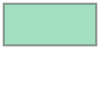

In [99]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [100]:
FOOTPRINT.bounds

(-121.5812945, 50.2224308, -121.5440226, 50.2392182)

In [ ]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

In [102]:
# CONFIG 
# -------------
TGT_BANDS =  ['B04', 'B08']#'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
YEARS = ['2016','2017','2018','2019','2020','2021','2022']
BEGIN_MONTH = '01'
END_MONTH = '12'
MAX_CLOUD = 5
READ_IN_CHUNK = 4096
RESOLUTION = 10
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
SYNCHRONOUS = False # Write bands out one at a time - use if resources can't handle all bands at once for AOI
# -------------

In [103]:
item_dict = []
for year in YEARS:
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    items = api.search(
        collections = ['sentinel-2-l2a'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD}, "s2:mgrs_tile":{"eq":'10UFA'}},
        datetime = date_range,
    ).get_all_items()
    
    
    print(f'\tFound {len(items)} items')
    # planetarycomputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    item_dict+=signed_items
        # Iterate over bands and build composite DAG
    for band in TGT_BANDS:
        clear_output(wait=True) # clear Jupyter Cell output
        print(f'[Processing {band}]')
        
    # print(signed_items)

# Convert STAC query into a xarray.DataArray
# with stackstac
print('\t[Converting STAC query to DataArray]')
data = (
    stackstac.stack(
        item_dict,
        assets=TGT_BANDS, 
        chunksize=READ_IN_CHUNK, # Set chunksize
        resolution=RESOLUTION, # Set all bands res to this
        bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
        epsg = 32610
    ).where(lambda x: x > 0, other=np.nan).assign_coords( # Convert nodata zero to np.nan
        band=lambda x: x.common_name.rename("band"),  # use common names
        time=lambda x: x.time.dt.round(
            "D"
        ))  
)
data

[Processing B08]
	[Converting STAC query to DataArray]


/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


<xarray.DataArray 'stackstac-f26ac7379de0089bbce16b1be4ce3848' (time: 66,
                                                                band: 2,
                                                                y: 193, x: 271)>
dask.array<where, shape=(66, 2, 193, 271), dtype=float64, chunksize=(1, 1, 193, 271), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2016-08-17...
    id                                       (time) <U54 'S2A_MSIL2A_20160816...
  * band                                     (band) <U3 'red' 'nir'
  * x                                        (x) float64 6.012e+05 ... 6.039e+05
  * y                                        (y) float64 5.566e+06 ... 5.564e+06
    s2:datatake_id                           (time) <U34 'GS2A_20160816T18592...
    ...                                       ...
    gsd                                      float64 10.0
    proj:shape                               object {10980}
    common_name                              (band) <U3 'red' 'nir'
    center_wavelength                        (band) float64 0.665 0.842
    full_width_half_max                      (band) float64 0.038 0.145
    epsg                                     int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(601160, 5564320, 603870, 5566...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 601160.00|\n| 0.00,-10.00, 5566250.00|\n| 0.0...
    resolution:  10

## 3. Calculating the NDVI

Now that we have all the data in the right place, let's compute the NDVI on the data! To efficiently get the NDVI for all the data, we will need a few helper functions.

### 3.1 Normalization Function

Normalization is a procedure of adjusting values measured on a different scale to a common scale. We will normalize the data so the computation of NDVI is done on the same scale of values. 

In [104]:
def normalize(array):
    norm = (array - array.min()) / (array.max() - array.min())
    return norm

In [105]:
normalized = normalize(data)

normalized

<xarray.DataArray 'stackstac-f26ac7379de0089bbce16b1be4ce3848' (time: 66,
                                                                band: 2,
                                                                y: 193, x: 271)>
dask.array<truediv, shape=(66, 2, 193, 271), dtype=float64, chunksize=(1, 1, 193, 271), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2016-08-17...
    id                                       (time) <U54 'S2A_MSIL2A_20160816...
  * band                                     (band) <U3 'red' 'nir'
  * x                                        (x) float64 6.012e+05 ... 6.039e+05
  * y                                        (y) float64 5.566e+06 ... 5.564e+06
    s2:datatake_id                           (time) <U34 'GS2A_20160816T18592...
    ...                                       ...
    gsd                                      float64 10.0
    proj:shape                               object {10980}
    common_name                              (band) <U3 'red' 'nir'
    center_wavelength                        (band) float64 0.665 0.842
    full_width_half_max                      (band) float64 0.038 0.145
    epsg                                     int64 32610

### 3.2 Calculate the NDVI of each temporal slice

The next step is to calculate NDVI. To do so we will use XArray's multispectral module which enables us to calculate a variety of indices.

In [106]:
%%time

ndvi_aggs = [ms.ndvi(x.sel(band="nir"), x.sel(band="red")) for x in data]

ndvi = xr.concat(ndvi_aggs, dim="time")

CPU times: user 763 ms, sys: 5.69 ms, total: 768 ms
Wall time: 767 ms


## 4. Visualizing the Results

### 4.1 Plotting
To see how the NDVI changes over time, we can visualize our images using **plot**. 

The cell below groups the images according to time and plots the entire dataset. The greener a pixel is the higher it's NDVI. In this example one can clearly see the damage caused by a wildfire that devastated Lytton, BC in 2021.

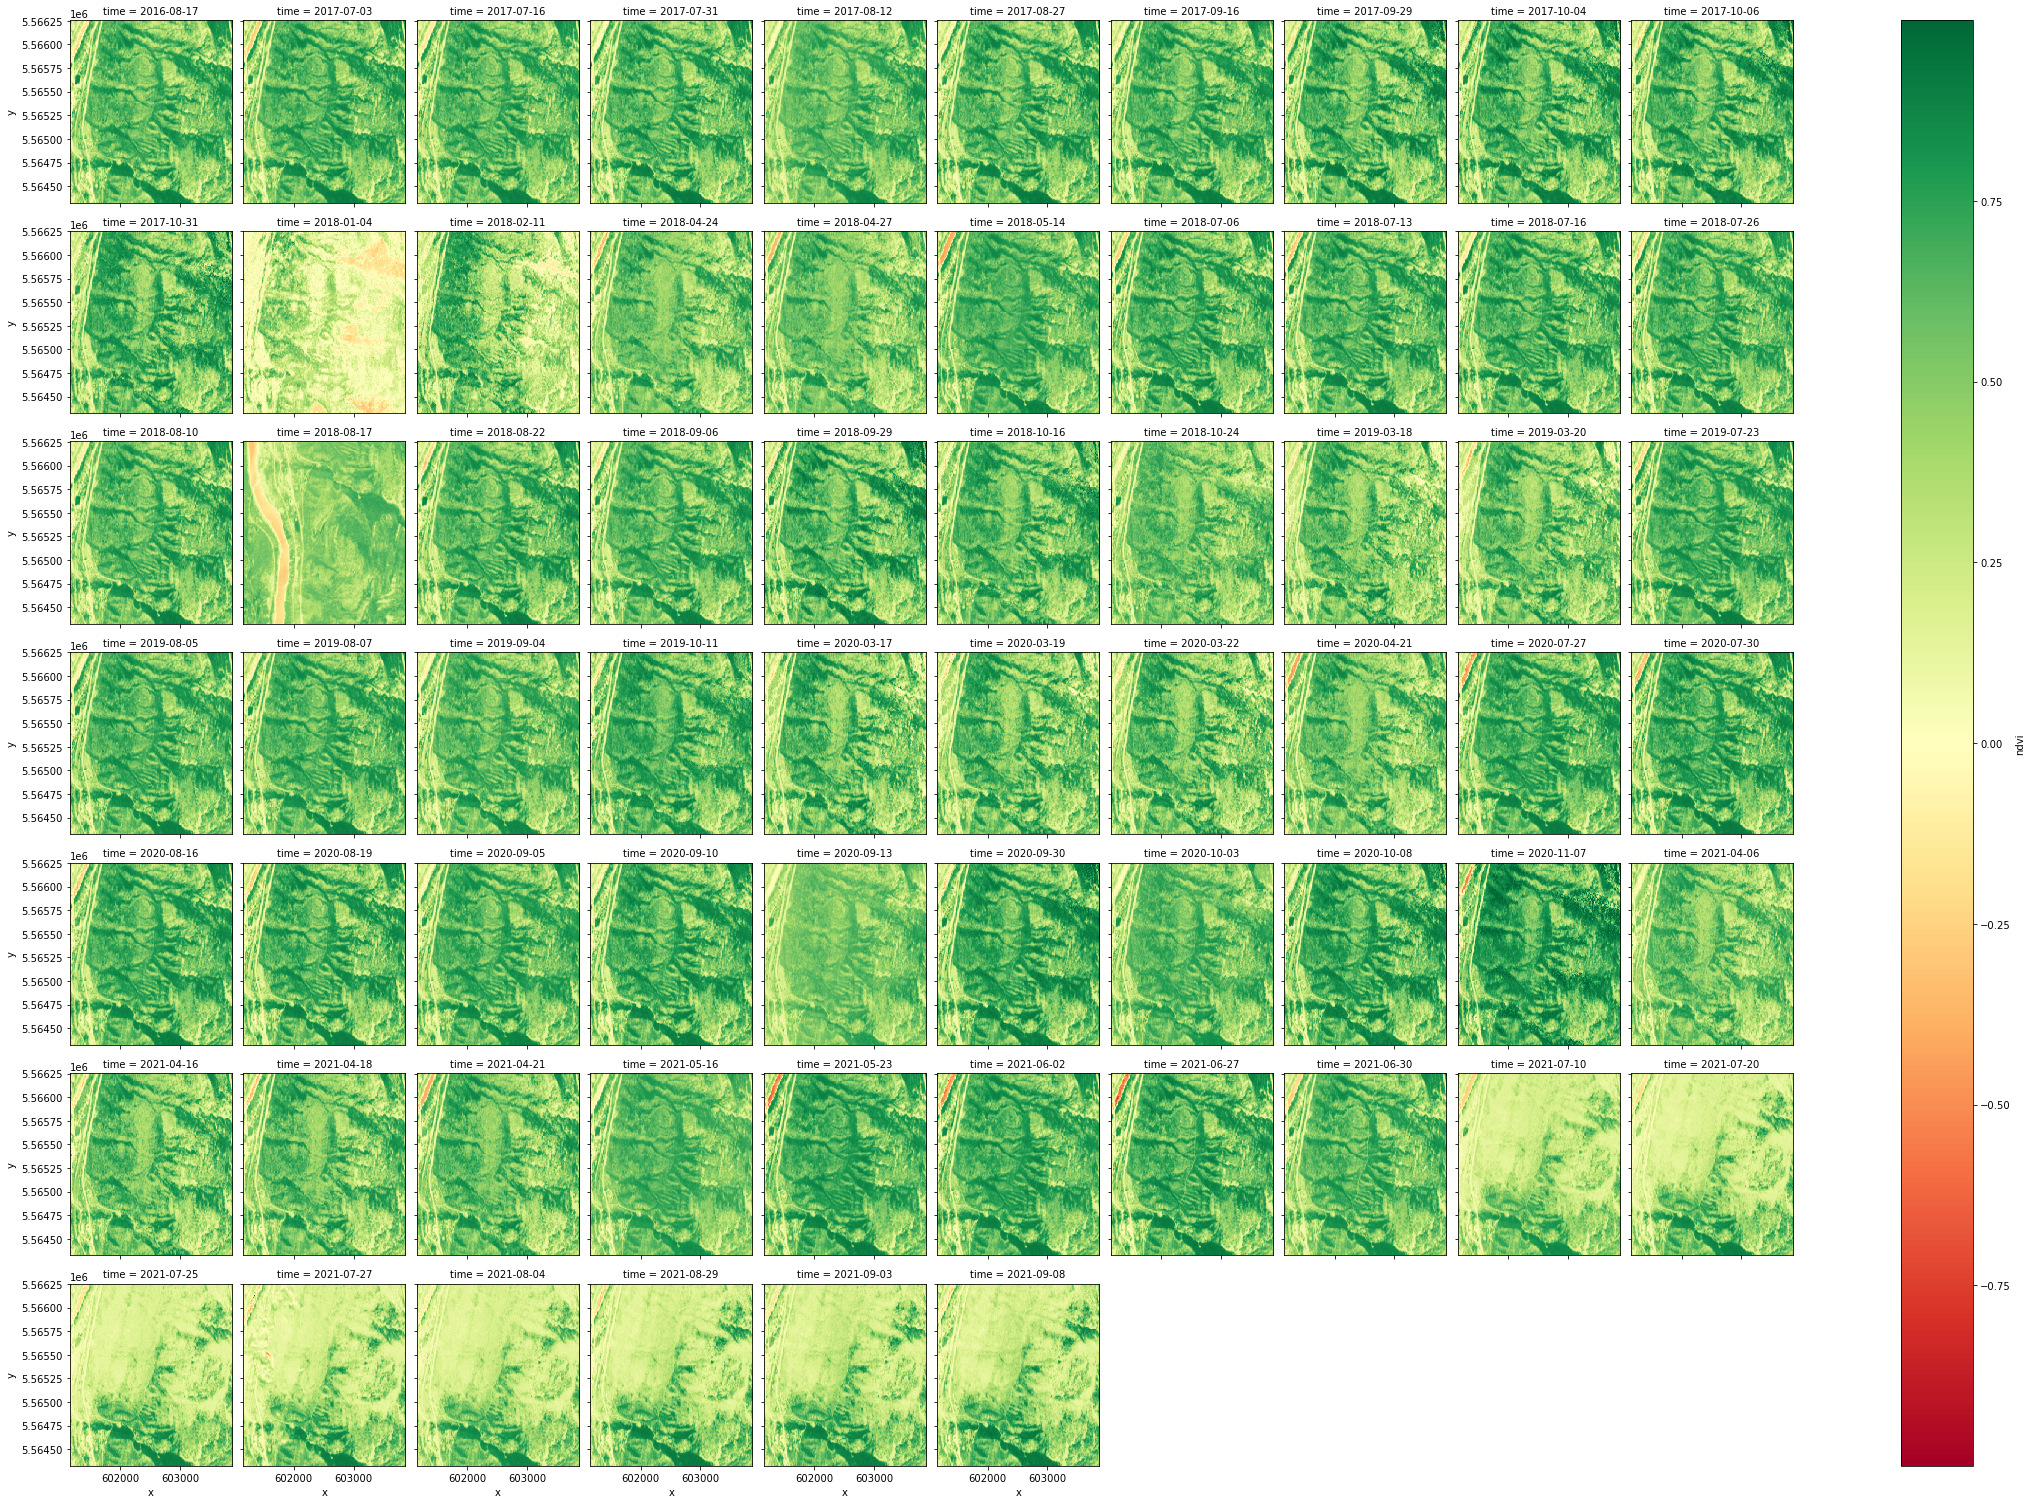

In [107]:
ndvi.plot.imshow(x="x", y="y", col="time", col_wrap=10, cmap="RdYlGn")

### 4.2 Creating a GIF

To stack our images and animate them as a GIF we can use geogif's **gif** function.
It allows us to specify our frames per second and the color map we wish to use.

CPU times: user 615 ms, sys: 68.1 ms, total: 684 ms
Wall time: 10.4 s


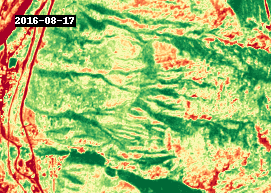

In [108]:
%%time
gif(ndvi.compute(), fps=5, cmap="RdYlGn")

### 4.3 Analysis

The GIF above shows NDVI between 2016 and 2021, around the town of Lytton, British Columbia. The most notable changes other than seasonal variability are attributed to wildfire, such as the devastating fire that took place in 2021. 

Let's plot the change in NDVI for the year of 2021 on a line graph. First let's mark an area of interest. You can use the website https://www.geoplaner.com to get the coordinates in Universal Transverse Mercator(UTM). Let's set a buffer of 500 meters to analyize values within that radius.

In [109]:
#UTM zone 18N coordinates near Lytton, BC
xcen = 601977.31
ycen = 5565053.51
buf = 500  # look at point +/- 5km

Text(0.5, 1.0, 'Annual change of NDVI (2020)')

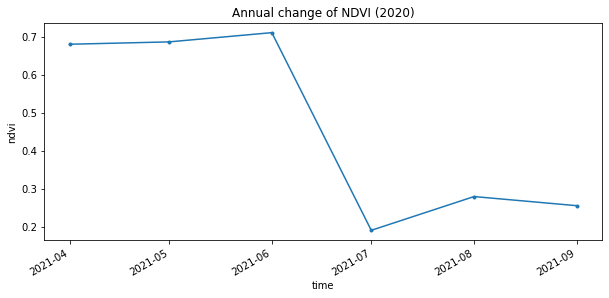

In [110]:
annual = ndvi.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen+buf,ycen-buf), time=slice('2021-01-01', '2021-12-01'))
annual_timeseries = annual.resample(time='1MS').mean().persist()

annual_timeseries.isel(x=2,y=2).plot.line(figsize=(10,4), marker='.')
plt.title("Annual change of NDVI (2020)")

The graph above shows the wildfire caused a sharp decline in NDVI values during the summer of 2021, which was followed by a small recovery. 

To ensure that the drop in NDVI we are seeing isn't a seasonal trend let's look at the variation over five years.

Text(0.5, 1.0, 'NDVI Variation over 5 years')

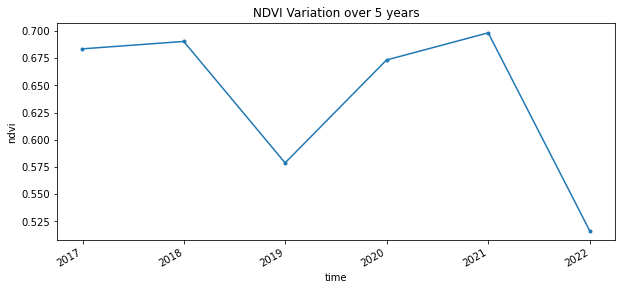

In [111]:
full_variation = ndvi.sel(x=slice(xcen-buf,xcen+buf), y=slice(ycen+buf,ycen-buf))
full_timeseries = full_variation.resample(time='A').mean().persist()

full_timeseries.isel(x=1,y=1).plot(figsize=(10,4), marker='.')
plt.title("NDVI Variation over 5 years")

As you see there appears to have been another fire in 2018, although it was not as devastating as the 2021 fire.  

After completing this notebook you should feel comfortable querying data from a STAC server, calculating an index using Sentinel2 data, and visualizing your results. 

***Make sure to always explicitly shut down computing resources when you're not using them!***

In [112]:
cluster.shutdown()
client.close()